![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [107]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import any additional modules and start coding 
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

Initial exploring of our dataset

First we read the `rental_info.csv` file into a pandas dataframe, and print the first few rows.

In [108]:
# Reading the csv file into a pandas df
rental_df = pd.read_csv('rental_info.csv')
rental_df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


We can then inspect our dataframe's columns, to see each one's type and identify any rows with missing entries

In [109]:
# Print each columns' dtype, see if there are any missing values
rental_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [110]:
# See if there are any missing values in our df
rental_df.isna().sum()

rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

Before visualizing/exploring some of the columns that might be of interest, we can obtain the rental length in days by taking the difference in days between the `rental_date` and `return_date` columns.

We first convert these two columns into their corresponding data type:

In [111]:
rental_df[['rental_date','return_date']] = rental_df[['rental_date','return_date']].apply(pd.to_datetime)

We can then get the length of the rentals by taking the difference between these columns in days:

In [112]:
rental_df['rental_length_days'] = (rental_df['return_date'] - rental_df['rental_date']).dt.days

In [113]:
rental_df[['rental_date','return_date','rental_length_days']].sample(10)

,rental_date,return_date,rental_length_days
14350,2005-08-02 03:25:55+00:00,2005-08-10 22:01:55+00:00,8
1738,2005-08-18 19:52:12+00:00,2005-08-23 01:00:12+00:00,4
12992,2005-07-27 23:18:17+00:00,2005-07-30 22:55:17+00:00,2
5427,2005-07-31 19:17:24+00:00,2005-08-03 21:27:24+00:00,3
4948,2005-07-11 00:21:54+00:00,2005-07-17 04:26:54+00:00,6
5656,2005-08-01 02:22:00+00:00,2005-08-05 05:17:00+00:00,4
3755,2005-05-31 15:15:43+00:00,2005-06-07 16:02:43+00:00,7
5860,2005-08-23 18:43:46+00:00,2005-08-27 20:43:46+00:00,4
13441,2005-07-28 13:49:40+00:00,2005-08-01 09:34:40+00:00,3
9808,2005-08-02 23:26:51+00:00,2005-08-07 23:55:51+00:00,5


We can also add a couple of binary (dummy) columns to let us know whether the given movie rental includes deleted scenes and/or behind the scenes material:

In [114]:
rental_df['special_features'].unique()

array(['{Trailers,"Behind the Scenes"}', '{Trailers}',
       '{Commentaries,"Behind the Scenes"}', '{Trailers,Commentaries}',
       '{"Deleted Scenes","Behind the Scenes"}',
       '{Commentaries,"Deleted Scenes","Behind the Scenes"}',
       '{Trailers,Commentaries,"Deleted Scenes"}',
       '{"Behind the Scenes"}',
       '{Trailers,"Deleted Scenes","Behind the Scenes"}',
       '{Commentaries,"Deleted Scenes"}', '{Commentaries}',
       '{Trailers,Commentaries,"Behind the Scenes"}',
       '{Trailers,"Deleted Scenes"}', '{"Deleted Scenes"}',
       '{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}'],
      dtype=object)

In [115]:
rental_df['deleted_scenes'] = rental_df['special_features'].apply(lambda x: 1 if 'deleted scenes' in x.lower() else 0)
rental_df['behind_the_scenes'] = rental_df['special_features'].apply(lambda x: 1 if 'behind the scenes' in x.lower() else 0)

In [116]:
rental_df[['special_features','deleted_scenes','behind_the_scenes']].sample(10)

,special_features,deleted_scenes,behind_the_scenes
13109,{Trailers},0,0
9162,"{""Behind the Scenes""}",0,1
12088,"{Commentaries,""Deleted Scenes"",""Behind the Sce...",1,1
7102,"{Trailers,Commentaries}",0,0
671,"{Commentaries,""Deleted Scenes"",""Behind the Sce...",1,1
14971,"{Trailers,Commentaries,""Deleted Scenes""}",1,0
6773,{Commentaries},0,0
6045,{Commentaries},0,0
7299,"{Trailers,Commentaries,""Behind the Scenes""}",0,1
12392,"{Commentaries,""Deleted Scenes""}",1,0


We can now make some plots of different kinds to help us visualize and better understand the distribution of our data, and maybe detect if there are some (unexpected) outliers in our dataset.

We can begin with a boxplot of some of the numerical columns, we can also add our binary columns as hue parameters, to see if there are any differences in the distributions in relation to them:

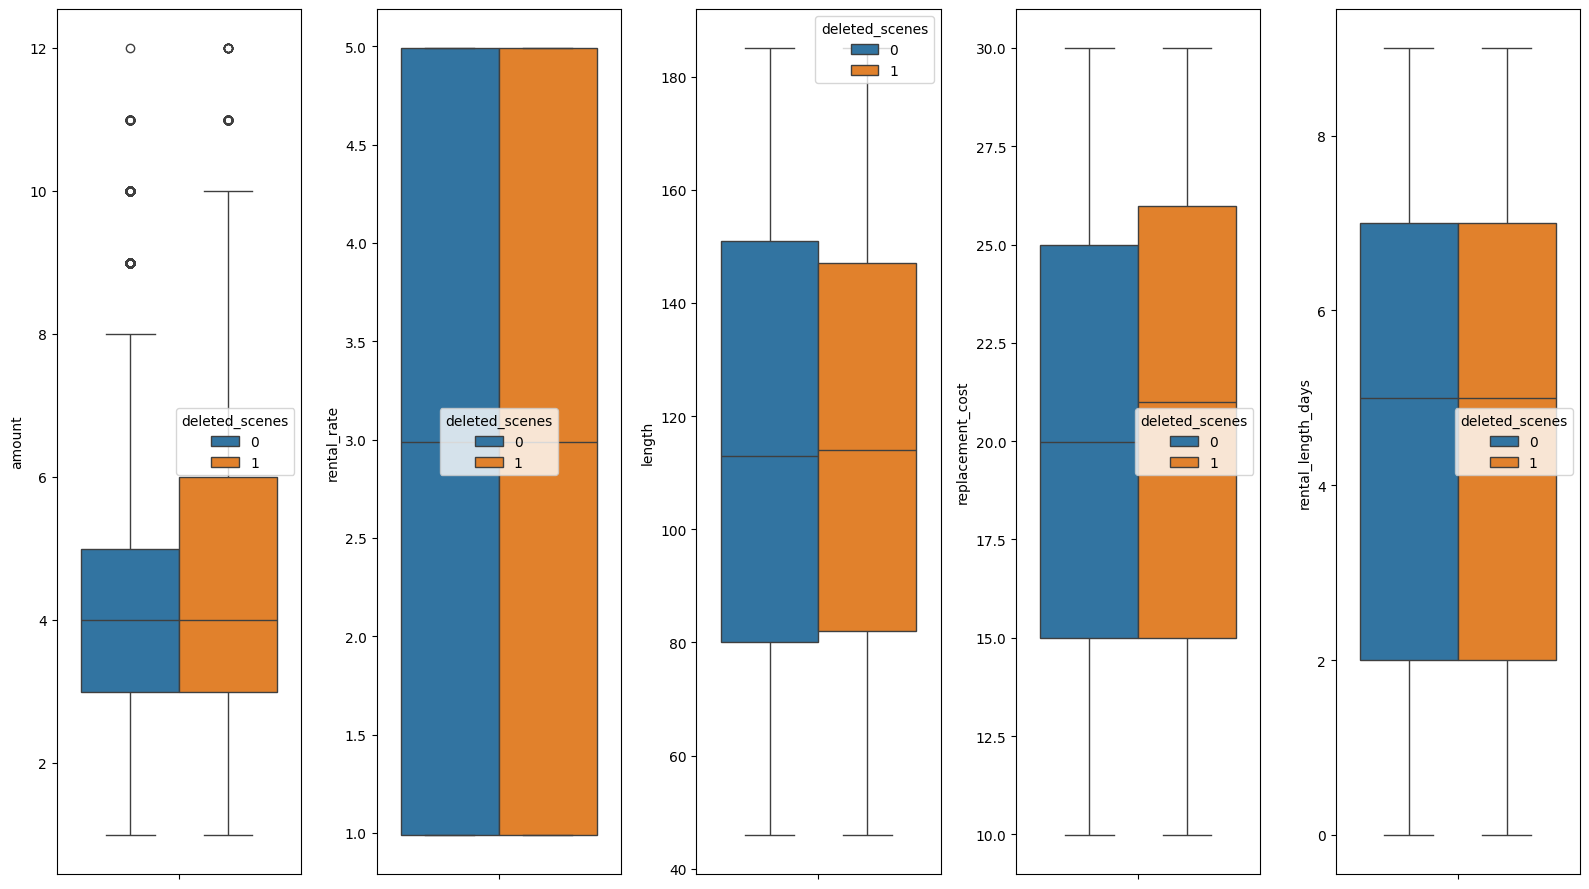

In [117]:
fig, ax = plt.subplots(1,5)
i = 0

for column in ['amount', 'rental_rate','length','replacement_cost','rental_length_days']:
    sns.boxplot(
        y = column,
        data = rental_df,
        hue = 'deleted_scenes',
        ax = ax[i]
    )
    
    i += 1

fig.set_size_inches(16,9)
fig.tight_layout()
fig.show()

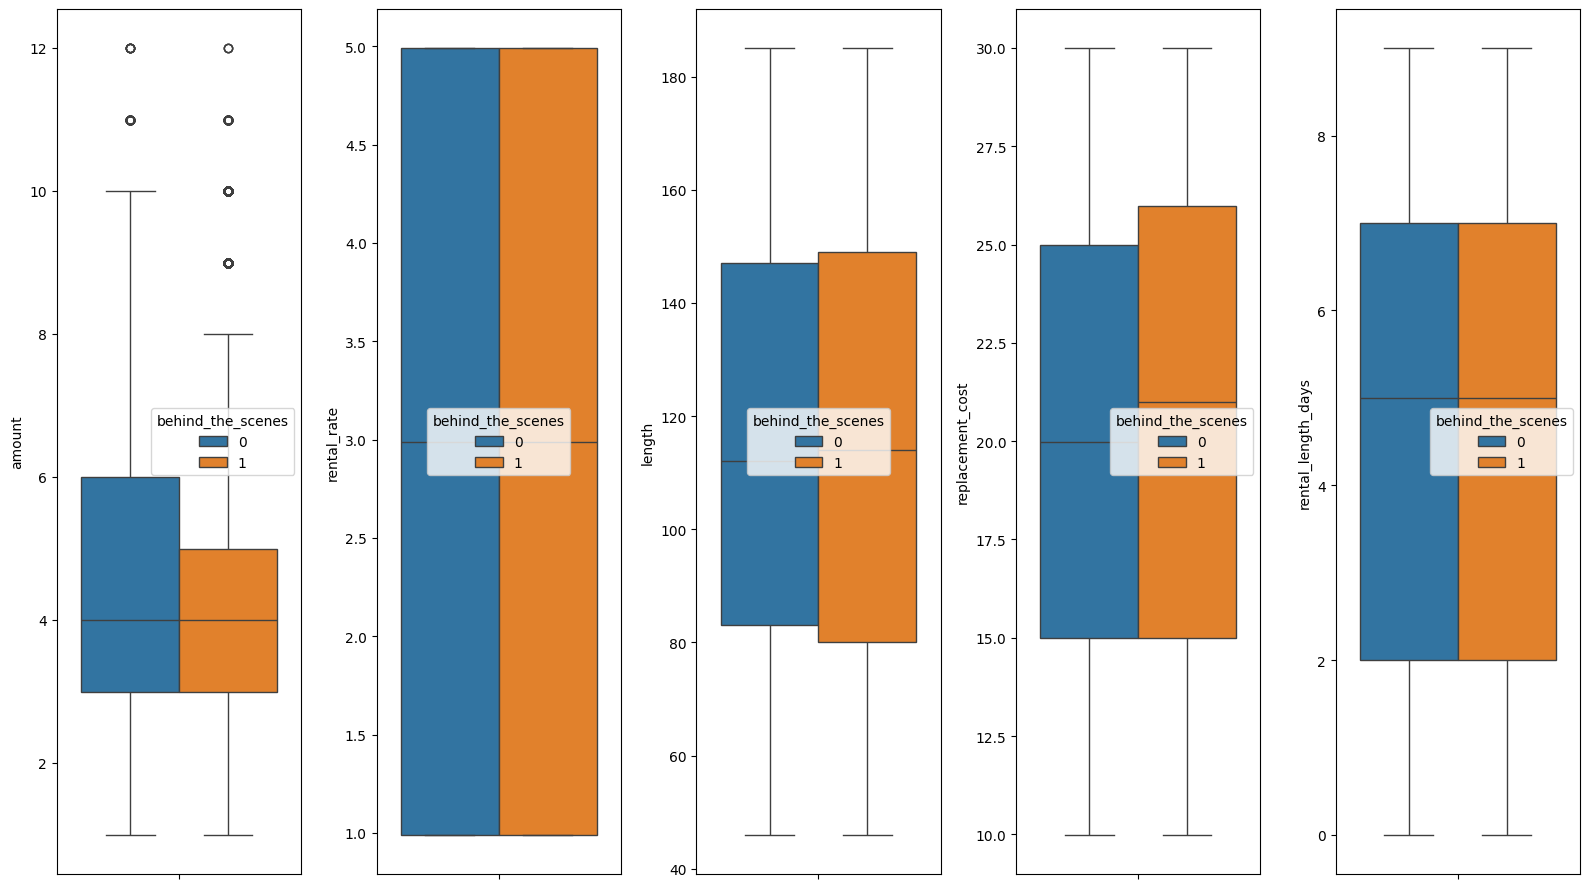

In [118]:
fig, ax = plt.subplots(1,5)
i = 0

for column in ['amount', 'rental_rate','length','replacement_cost','rental_length_days']:
    sns.boxplot(
        y = column,
        data = rental_df,
        hue = 'behind_the_scenes',
        ax = ax[i]
    )
    
    i += 1

fig.set_size_inches(16,9)
fig.tight_layout()
fig.show()

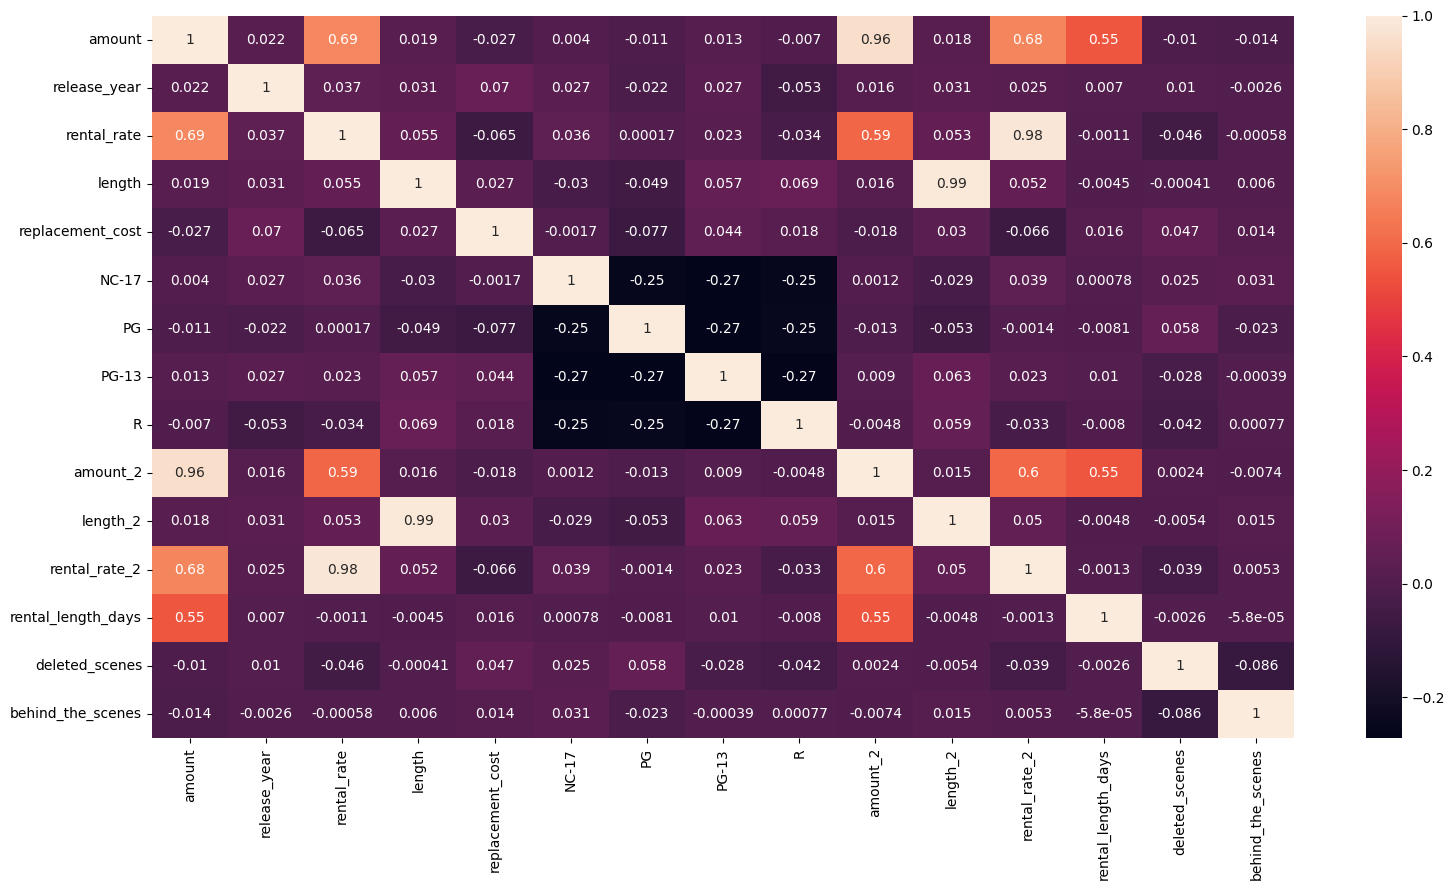

In [119]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(rental_df.corr(numeric_only=True),annot=True, ax = ax)
fig.tight_layout()
fig.show()

We can now select the features that might be helpful to our model.

In [120]:
X = rental_df.drop(columns=['rental_length_days','rental_date','return_date','special_features'])

In [121]:
y = rental_df['rental_length_days']

## Preprocessing our data

We can begin by splitting our data into train and test sets:

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

We can then use lasso regression to find the more significant features in our dataset:

In [123]:
from sklearn.linear_model import Lasso

In [124]:
lasso_reg = Lasso(alpha = 0.3, random_state=9)

lasso_reg.fit(X_train,y_train)

Lasso(alpha=0.3, random_state=9)

Using the `coef_` atribute of the Lasso model, we can then check which features have an actual (or significant) effect in the prediction of our target variable:

In [125]:
lasso_reg.coef_

array([ 5.84104424e-01,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  4.36220109e-02,  3.01167812e-06, -1.52983561e-01,
       -0.00000000e+00,  0.00000000e+00])

We can easily see which variables are selected by filtering our `X` dataframes by the columns that have a coefficient different from `0` and printing the column names:

In [126]:
lasso_coef = lasso_reg.coef_
X_train.iloc[:, lasso_coef > 0].columns

Index(['amount', 'amount_2', 'length_2'], dtype='object')

With this, we can filter both our `X_train` and `X_test` datasets by using this criteria:

In [127]:
X_lasso_train, X_lasso_test = X_train.iloc[:, lasso_coef > 0], X_test.iloc[:, lasso_coef > 0]

## Selecting and tuning our model

We can now go ahead and select our best model and hyperameters combination, for this, we can try with both a Linear Regression model and a Random Forest Regressor, and tune the latter one accordingly to find the best model/hyperparameters combination, since linear regression doesn't have any particular parameters that can be tuned.

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [129]:
linreg = LinearRegression()
linreg = linreg.fit(X_lasso_train, y_train)
y_test_pred = linreg.predict(X_lasso_test)
mse_lin_reg_lasso = mean_squared_error(y_test, y_test_pred)

In [130]:
print(mse_lin_reg_lasso)

4.812297241276244


Since our linear regression model yielded an MSE valu of 4.812, we can try with a tuned Random Forest Regressor model.

In [131]:
rfreg = RandomForestRegressor(random_state=9)

In [132]:
params = {
    'n_estimators' : np.arange(100, 550, 50),
    'max_depth' : [1, 2, 3],
    'min_samples_split' : [0.7, 0.9, 2]
}

In [133]:
reg = RandomizedSearchCV(
    estimator = rfreg,
    param_distributions = params,
    n_iter = 30,
    scoring = 'neg_mean_squared_error',
    random_state = 9
)

In [134]:
reg.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(random_state=9), n_iter=30,
                   param_distributions={'max_depth': [1, 2, 3],
                                        'min_samples_split': [0.7, 0.9, 2],
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500])},
                   random_state=9, scoring='neg_mean_squared_error')

In [135]:
reg.best_params_

{'n_estimators': 350, 'min_samples_split': 2, 'max_depth': 3}

After getting our best estimator parameters, we can then proceed to build a new model with them:

In [136]:
rf = RandomForestRegressor(n_estimators=reg.best_params_["n_estimators"], 
                           max_depth=reg.best_params_["max_depth"],
                           min_samples_split=reg.best_params_['min_samples_split'],
                           random_state=9)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
mse_random_forest= mean_squared_error(y_test, rf_pred)

In [137]:
print(mse_random_forest)

2.863146390856125


In [138]:
best_model = rf
best_mse = mse_random_forest